### Loading efficientnet and required libraries 

In [ ]:
!pip install efficientnet_pytorch torchtoolbox

     |████████████████████████████████| 58 kB 1.4 MB/s 
     |████████████████████████████████| 869 kB 582 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=4ec26c465a20a62c2cf4c1a4f8b21ea6949443952ee9cd673f071985229a5e24
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for lmdb: filename=lmdb-0.98-cp37-cp37m-linux_x86_64.whl size=273149 sha256=eb47cc72859389384e28a65c3898ecafe3c2b196bb3ae4cf7608ea2397c765f6
  Stored in directory: /root/.cache/pip/wheels/9e/24/96/783d4dddcf63e3f8cc92db8b3af3c70cf6d76398bff77f1d5e
Successfully built efficientnet-pytorch lmdb
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet

from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

In [ ]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


In [ ]:
# upload train dataframe
path = '/kaggle/input/jpeg-melanoma-256x256/'
train_df_2020 = pd.read_csv(path + 'train.csv')
train_df_2019 = pd.read_csv("/kaggle/input/jpeg-isic2019-256x256/train.csv")

In [ ]:
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


### k-fold to keep counts of patient replicates evenly distributed within each fold

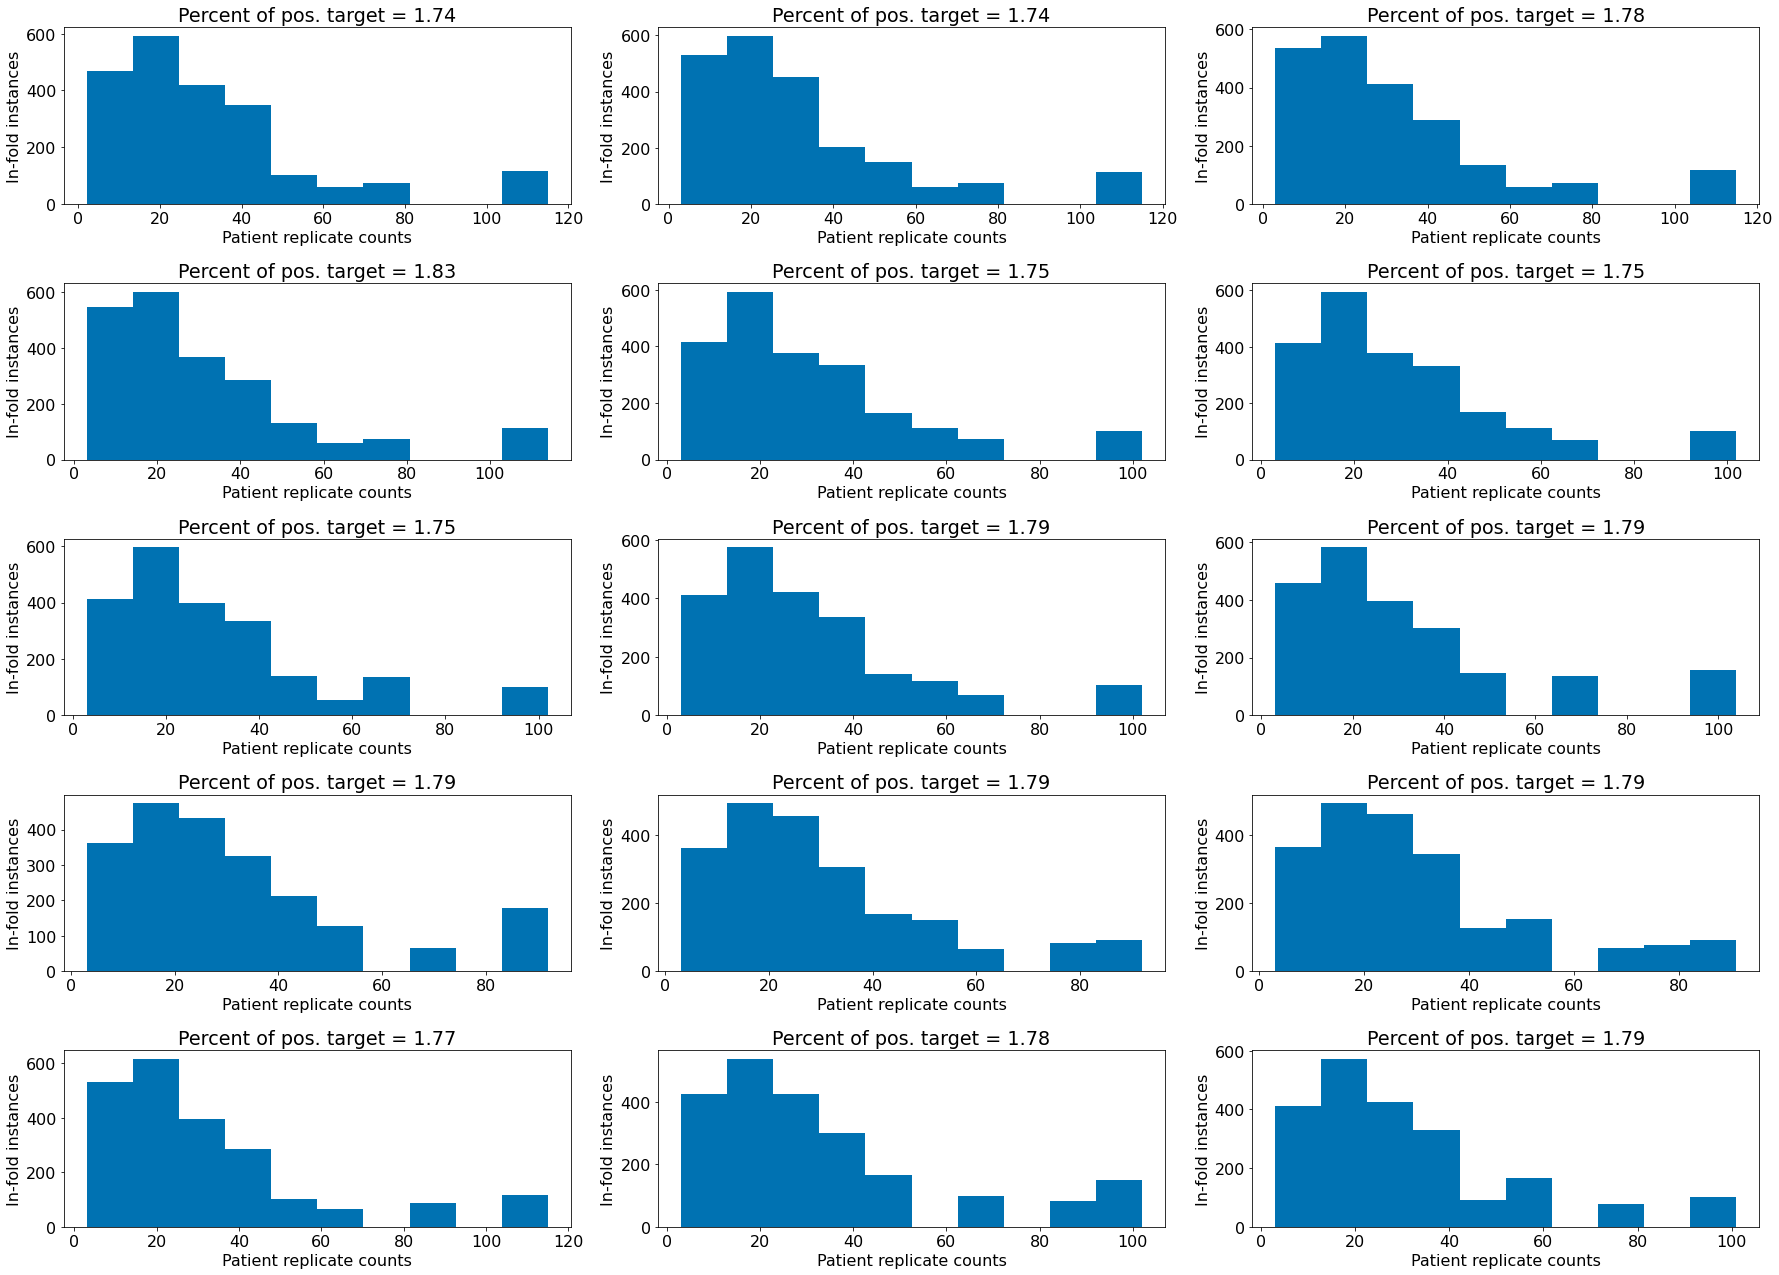

In [ ]:
unique_patient_ids, patient_counts = np.unique(train_df_2020['patient_id'].values, return_counts=True)
patient_to_count = {p_id:count for p_id, count in zip(unique_patient_ids, patient_counts)}

tfrecords = train_df_2020['tfrecord'].values 
folds = np.arange(15)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16,
                     'legend.framealpha':.5,
                     'legend.edgecolor':'k',
                     'axes.edgecolor':'k'})
plt.figure(figsize=(5*5, 6*3))
k = 1 
for f in folds:
    fold_df = train_df_2020.iloc[tfrecords == folds[f], :]

    fold_patient_ids = fold_df['patient_id'].values 
    fold_patient_counts = [patient_to_count[p] for p in fold_patient_ids]
    fold_target = fold_df['target'].values
    fold_p_target = 100 * sum(fold_target) / len(fold_target)

    plt.subplot(5, 3, k)
    k += 1
    plt.hist(fold_patient_counts)
    plt.xlabel("Patient replicate counts")
    plt.ylabel("In-fold instances")
    plt.title("Percent of pos. target = {:.2f}".format(fold_p_target))
    
plt.tight_layout()
plt.show()

In [ ]:
# 2020 data has 15 folds, while 2019 data has 30. Need to convert to system with 5 folds for each 
old_folds = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
new_folds = [-1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,  2,  2,  2,  2,  2]
converter = {o:n for o, n in zip(old_folds, new_folds)}
tf_2020 = train_df_2020.tfrecord.values
tf_2020_fixed = [converter[o] for o in tf_2020]
train_df_2020['tfrecord'] = tf_2020_fixed

old_folds = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
new_folds = [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]
converter = {o:n for o, n in zip(old_folds, new_folds)}
tf_2019 = train_df_2019.tfrecord.values
tf_2019_fixed = [converter[o] for o in tf_2019]
train_df_2019['tfrecord'] = tf_2019_fixed

train_df_allsamples = pd.concat((train_df_2020, train_df_2019))
tfrecords = train_df_allsamples.tfrecord.values
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,1,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,2,6000,4000


In [ ]:
# create a dictionary that links image names to path 
img_names_2019 = train_df_2019.image_name.values 
path_dict = {img_name:"/kaggle/input/jpeg-isic2019-256x256/train/" for img_name in img_names_2019}

img_names_2020 = train_df_2020.image_name.values 
for img_name in img_names_2020:
    path_dict[img_name] = "/kaggle/input/jpeg-melanoma-256x256/train/"
    
test_names = test_df.image_name.values
for img_name in test_names:
    path_dict[img_name] = "/kaggle/input/jpeg-melanoma-256x256/test/"

### Define data loaders using PyTorch Dataset class

In [ ]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df_allsamples[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform for all images 
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=8),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# additional transform to augment positive samples 
transform_augment_h = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_dict):
        # 1. Initialize file paths or a list of file names.
        self.path_dict = path_dict
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path_dict[img_name] + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform) 
        img_processed = transform_basic(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_dict):
        # 1. Initialize file paths or a list of file names.
        self.path_dict = path_dict
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path_dict[img_name] + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_dict):
        # 1. Initialize file paths or a list of file names.
        self.path_dict = path_dict
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).

        # load X
        img_name = self.df['image_name'].values[index]
        img_path = self.path_dict[img_name] + img_name + ".jpg"
        img = plt.imread(img_path)

        # determine meta data
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])

        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data

    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

def AugmentBatch(images, labels):
    
    # find positives in data set 
    for img, label in zip(images, labels):
        if label == 1:
            # transform image with horizontal flip
            img_aug = transform_augment_h(img).unsqueeze_(0)
            # append set of augmented images and labels 
            images = torch.cat((images, img_aug)) 
            labels = torch.cat((labels, torch.Tensor([label])))

    # shuffle 
    shuffle_inds = torch.randperm(images.size()[0])
    images = images[shuffle_inds, :, :, :]
    labels = labels[shuffle_inds]
    return images, labels

### Taining neural network model

In [ ]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=1024)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.LeakyReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0

Fold [1/3], Epoch [1/10], Step [50/370], ROC AUC: 0.946, Loss: 0.181, K-S stat: 0.754


Fold [1/3], Epoch [1/10], Step [100/370], ROC AUC: 0.960, Loss: 0.144, K-S stat: 0.797


Fold [1/3], Epoch [1/10], Step [150/370], ROC AUC: 0.864, Loss: 0.271, K-S stat: 0.621


Fold [1/3], Epoch [1/10], Step [200/370], ROC AUC: 0.979, Loss: 0.111, K-S stat: 0.865


Fold [1/3], Epoch [1/10], Step [250/370], ROC AUC: 0.954, Loss: 0.152, K-S stat: 0.828


Fold [1/3], Epoch [1/10], Step [300/370], ROC AUC: 0.937, Loss: 0.152, K-S stat: 0.827


Fold [1/3], Epoch [1/10], Step [350/370], ROC AUC: 0.989, Loss: 0.124, K-S stat: 0.895



/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



Fold [1/3], Epoch [1/10], Val ROC AUC: 0.919, Val K-S stat: 0.672

Saving model...

Fold [1/3], Epoch [2/10], Step [50/370], ROC AUC: 0.938, Loss: 0.135, K-S stat: 0.833


Fold [1/3], Epoch [2/10], Step [100/370], ROC AUC: 0.960, Loss: 0.123, K-S stat: 0.777


Fold [1/3], Epoch [2/10], Step [150/370], ROC AUC: 0.924, Loss: 0.182, K-S stat: 0.778


Fold [1/3], Epoch [2/10], Step [200/370], ROC AUC: 0.985, Loss: 0.092, K-S stat: 0.917


Fold [1/3], Epoch [2/10], Step [250/370], ROC AUC: 0.954, Loss: 0.208, K-S stat: 0.878


Fold [1/3], Epoch [2/10], Step [300/370], ROC AUC: 0.936, Loss: 0.163, K-S stat: 0.745


Fold [1/3], Epoch [2/10], Step [350/370], ROC AUC: 0.964, Loss: 0.166, K-S stat: 0.797


Fold [1/3], Epoch [2/10], Val ROC AUC: 0.933, Val K-S stat: 0.710

Saving model...

Fold [1/3], Epoch [3/10], Step [50/370], ROC AUC: 0.978, Loss: 0.111, K-S stat: 0.876


Fold [1/3], Epoch [3/10], Step [100/370], ROC AUC: 0.984, Loss: 0.110, K-S stat: 0.877


Fold [1/3], Epoch [3/10], Step [

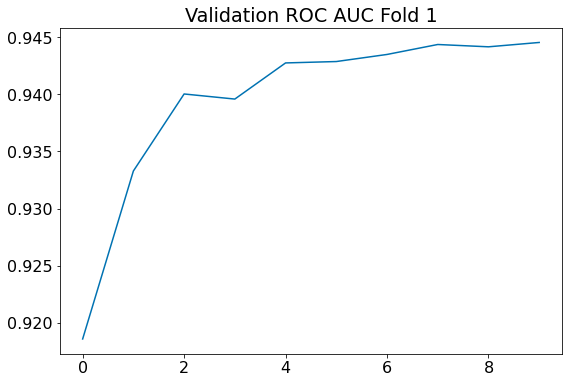

Loaded pretrained weights for efficientnet-b0

Fold [2/3], Epoch [1/10], Step [50/370], ROC AUC: 0.913, Loss: 0.254, K-S stat: 0.781


Fold [2/3], Epoch [1/10], Step [100/370], ROC AUC: 0.947, Loss: 0.194, K-S stat: 0.846


Fold [2/3], Epoch [1/10], Step [150/370], ROC AUC: 0.901, Loss: 0.257, K-S stat: 0.708


Fold [2/3], Epoch [1/10], Step [200/370], ROC AUC: 0.974, Loss: 0.177, K-S stat: 0.814


Fold [2/3], Epoch [1/10], Step [250/370], ROC AUC: 0.934, Loss: 0.240, K-S stat: 0.737


Fold [2/3], Epoch [1/10], Step [300/370], ROC AUC: 0.986, Loss: 0.118, K-S stat: 0.923


Fold [2/3], Epoch [1/10], Step [350/370], ROC AUC: 0.932, Loss: 0.146, K-S stat: 0.827


Fold [2/3], Epoch [1/10], Val ROC AUC: 0.910, Val K-S stat: 0.657

Saving model...

Fold [2/3], Epoch [2/10], Step [50/370], ROC AUC: 0.990, Loss: 0.087, K-S stat: 0.899


Fold [2/3], Epoch [2/10], Step [100/370], ROC AUC: 0.952, Loss: 0.112, K-S stat: 0.804


Fold [2/3], Epoch [2/10], Step [150/370], ROC AUC: 0.985, Loss: 0.137,

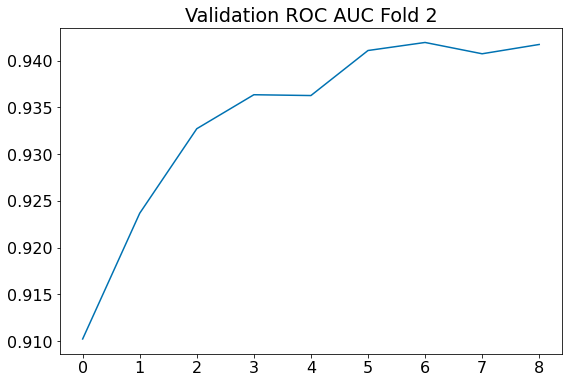

Loaded pretrained weights for efficientnet-b0

Fold [3/3], Epoch [1/10], Step [50/370], ROC AUC: 0.905, Loss: 0.232, K-S stat: 0.714


Fold [3/3], Epoch [1/10], Step [100/370], ROC AUC: 0.940, Loss: 0.168, K-S stat: 0.843


Fold [3/3], Epoch [1/10], Step [150/370], ROC AUC: 0.895, Loss: 0.257, K-S stat: 0.660


Fold [3/3], Epoch [1/10], Step [200/370], ROC AUC: 0.951, Loss: 0.147, K-S stat: 0.790


Fold [3/3], Epoch [1/10], Step [250/370], ROC AUC: 0.963, Loss: 0.178, K-S stat: 0.783


Fold [3/3], Epoch [1/10], Step [300/370], ROC AUC: 0.932, Loss: 0.229, K-S stat: 0.720


Fold [3/3], Epoch [1/10], Step [350/370], ROC AUC: 0.976, Loss: 0.110, K-S stat: 0.857


Fold [3/3], Epoch [1/10], Val ROC AUC: 0.906, Val K-S stat: 0.645

Saving model...

Fold [3/3], Epoch [2/10], Step [50/370], ROC AUC: 0.987, Loss: 0.107, K-S stat: 0.898


Fold [3/3], Epoch [2/10], Step [100/370], ROC AUC: 0.967, Loss: 0.138, K-S stat: 0.856


Fold [3/3], Epoch [2/10], Step [150/370], ROC AUC: 0.932, Loss: 0.209,

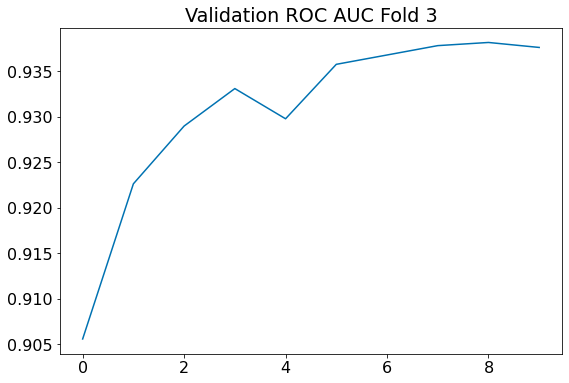

In [ ]:
# Train the model
# Use the prebuilt data loader.
train_path = path + "train/"
test_path  = path + "test/"

# define batch size and accumulation steps 
num_epochs = 10
batchsize  = 106
accumulation_steps = 1 # ~ sort of like making an effective batchsize = acc.steps * batchsize ? 
evaluation_steps = 50
set_patience = 3
verbose = True

# record out-of-fold predictions and test predictions 
nn_oof = np.zeros(len(train_df_allsamples))
nn_predictions = np.zeros(len(test_df))

# create a test loader 
test_dataset = TestDataset(test_df, path_dict)                                              
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize) 
        
# set k-folds
fold_sets = [0, 1, 2]

# loop through every fold 
for f, fold_set in enumerate(fold_sets):
    # initialize new model for each fold 
    ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
    model = MyENet(ENet).to(device)
    path_to_model = 'model_{}.ckpt'.format(f+1)
    
    # reset best val and patience 
    best_val = 0
    ks_stat = 0
    patience = set_patience
    
    # define lr and optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.BCELoss()
    
    # scheduler reduces learning rate by factor of 10 when val auc does not improve
    scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=1e-6, mode='max', patience=0, verbose=True)
    
    # pull the training and validation data for each fold
    inds = np.in1d(tfrecords, np.array(fold_set))
    train_df = train_df_allsamples.iloc[~inds, :]
    val_df = train_df_allsamples.iloc[inds, :]

    # evaluate performance on validation data 
    train_dataset = TrainDataset(train_df, path_dict)                                              
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True) 
    
    # evaluate performance on validation data 
    valid_dataset = ValidDataset(val_df, path_dict)                                              
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batchsize) 
    
    # save validation statistics 
    val_roc = []
    val_ks_stat = []
    
    # Reset gradients
    for epoch in range(num_epochs):
        
        # set up model for training     
        model.train()
        for i, (images, meta_data, labels) in enumerate(train_loader):

            # augment the batch with more positive samples 
            images, labels = AugmentBatch(images, labels)
            
            # send images and labels to gpu or cpu RAM 
            images = images.to(device)
            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)   
            
            # Compute loss 
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps                # Normalize loss (if averaged)
            loss.backward()                                 # Backward pass
            if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
                optimizer.step()                            # Now we can do an optimizer step
                model.zero_grad()                           # Reset gradients tensors
            
            # calculate performance 
            train_targets = np.array(labels.cpu().numpy(), np.int)
            train_predictions = outputs.detach().cpu().numpy().ravel()

            # if positive samples existed in batch 
            if sum(train_targets)[0] > 0:
                fpr, tpr, _ = roc_curve(train_targets, train_predictions)
                roc = auc(fpr, tpr)
                
                ks_stat, p = ks_2samp(np.array(train_predictions).ravel()[np.array(train_targets).ravel()==0], 
                                   np.array(train_predictions).ravel()[np.array(train_targets).ravel()==1])

                if verbose and (i+1) % evaluation_steps == 0:
                    # Print performance on minibatch train data 
                    print ('\nFold [{}/{}], Epoch [{}/{}], Step [{}/{}], ROC AUC: {:.3f}, Loss: {:.3f}, K-S stat: {:.3f}\n'
                       .format(f+1, len(fold_sets), epoch+1, num_epochs, i+1, len(train_loader), roc, loss.detach().cpu().numpy(), ks_stat))
                
        
        # Evaluate validation data at end of each epoch
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for j, (images, meta_data, labels) in enumerate(valid_loader):
                images = images.to(device)

                labels = torch.reshape(labels, [len(labels), 1])
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Store predictions and true values 
                valid_predictions += list(outputs.detach().cpu().numpy())
                valid_targets += list(labels.cpu().numpy())

        # Calculate performance statistics on validation data 
        fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
        val_roc_epoch = auc(fpr, tpr)
        val_roc.append(val_roc_epoch)
        val_ks_stat_epoch, p = ks_2samp(np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==0], 
                                        np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==1])
        val_ks_stat.append(val_ks_stat_epoch)

        print('\nFold [{}/{}], Epoch [{}/{}], Val ROC AUC: {:.3f}, Val K-S stat: {:.3f}\n'
               .format(f+1, len(fold_sets), epoch+1, num_epochs, val_roc_epoch, val_ks_stat_epoch))

        # learning rate is reduced if val roc doesn't improve 
        scheduler.step(val_roc_epoch)
        
        # Save model if validation performance improved 
        if val_roc_epoch > best_val:
            best_val = val_roc_epoch
            # patience = set_patience (takes too long to reset patience every time the score improves)     
            print("Saving model...")
            torch.save(model.state_dict(), path_to_model)  
        else:
            # re-do epoch with the best model and a reduced learning rate
            model.load_state_dict(torch.load(path_to_model))
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
                break

    # Load best model from fold (in case last epoch was not best)
    model.load_state_dict(torch.load(path_to_model))
    
    # at the end of fold, use model to make predictions on testing data  
    model.eval()
    
    print("Making predictions on test data...")
    test_predictions = []
    with torch.no_grad():
        for i, (images, meta_data) in enumerate(test_loader):
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            
            # append predictions
            test_predictions += list(outputs.detach().cpu().numpy())
    test_predictions = np.array(test_predictions).ravel()
    
    # save out of fold predictions
    nn_oof[inds] += np.array(valid_predictions).ravel()
    
    # save test predictions 
    nn_predictions += test_predictions / len(fold_sets)

    # plot validation performance over epochs 
    plt.style.use('seaborn-colorblind')
    plt.rcParams.update({'font.size': 16, 
                         'legend.framealpha':1, 
                         'legend.edgecolor':'inherit'}) 
    plt.figure(figsize=(9, 6))

    plt.plot(val_roc)
    plt.title("Validation ROC AUC Fold {}".format(f+1))
    plt.show()

### Show performance on out of fold validation samples

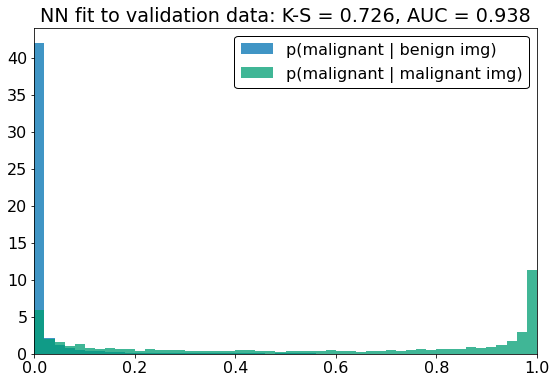

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = nn_oof
y_valid = train_df_allsamples['target'].values

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("NN fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

### Creating submission file

In [ ]:
image_names = test_df['image_name'].values

submission = pd.DataFrame()
submission["image_name"] = image_names
submission["target"] = nn_predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,image_name,target
0,ISIC_0052060,2.221259e-06
1,ISIC_0052349,6.391343e-05
2,ISIC_0058510,1.043245e-07
3,ISIC_0073313,1.129197e-05
4,ISIC_0073502,2.393955e-04
